In [190]:
#imports
import os;
import pandas as pd;

In [191]:
#list files
path = "D:\\random\\python\\OSRS_Prices"
files = os.listdir(path)
### print(files)

In [192]:
#pick files
rsbuddy_files = [f for f in files if 'rsbuddy' in f]
### print(rsbuddy_files)

In [193]:
#initialize empty dataframe
df = pd.DataFrame()

In [194]:
#Loop over list of files to append to empty dataframe
for f in rsbuddy_files:
    data = pd.read_csv(path+'\\'+f,names=['item_id','date','buyprice','sellprice','buyquantity','sellquantity'],header=None)
    df = df.append(data,sort=True)
df.drop_duplicates()
df.head()

,buyprice,buyquantity,date,item_id,sellprice,sellquantity
0,9907.0,1.0,2019-05-18 00:30:00,10392.0,5000.0,1.0
1,0.0,0.0,2019-05-18 01:30:00,10392.0,5000.0,1.0
2,0.0,0.0,2019-05-18 05:00:00,10392.0,5000.0,1.0
3,0.0,0.0,2019-05-18 15:30:00,10392.0,5000.0,1.0
4,0.0,0.0,2019-05-18 17:30:00,10392.0,5739.0,1.0


In [195]:
df2 = df.loc[df['item_id'] == 536]
df2 = df2.drop_duplicates()
min_d = df2.date.min()
max_d = df2.date.max()
df2 = df2.set_index('date')
df2.head()

,buyprice,buyquantity,item_id,sellprice,sellquantity
date,,,,,
2019-05-17 18:30:00,2527.0,1830.0,536.0,2526.0,5587.0
2019-05-17 19:00:00,2513.0,20055.0,536.0,2526.0,16407.0
2019-05-17 19:30:00,2533.0,12203.0,536.0,2487.0,27066.0
2019-05-17 20:00:00,2507.0,9952.0,536.0,2512.0,21063.0
2019-05-17 20:30:00,2508.0,16841.0,536.0,2505.0,22168.0


In [196]:
# identify outliers with standard deviation
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

# calculate summary statistics
data_mean, data_std = mean(df2['buyprice']), std(df2['buyprice'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in df2['buyprice'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df2['buyprice'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
for x in df2['buyprice']:
    if x < lower or x > upper:
        df2 = df2[df2.buyprice !=x]


Identified outliers: 1
Non-outlier observations: 943


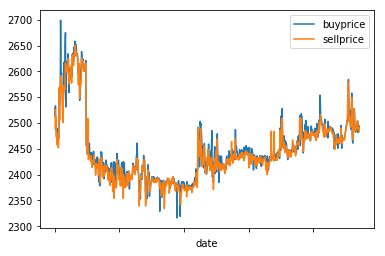

In [197]:
df3 = df2[['buyprice','sellprice']]
df3.plot()

Identified outliers: 1
Non-outlier observations: 943
Test Mean Squared Error (smaller the better fit): 217.162


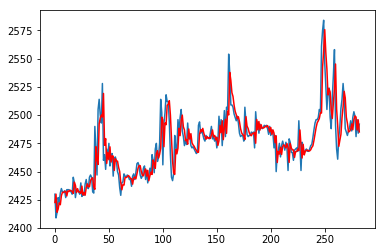

Identified outliers: 13
Non-outlier observations: 931
Test Mean Squared Error (smaller the better fit): 177.107


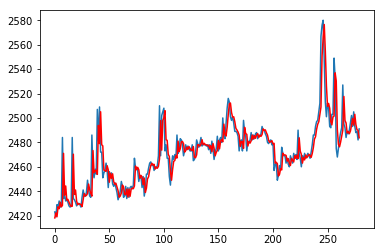

In [219]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def remove_outliers(data,parameter):
    df2=data
    # calculate summary statistics
    data_mean, data_std = mean(df2[parameter]), std(df2[parameter])
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in df2[parameter] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in df2[parameter] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    for x in df2[parameter]:
        if x < lower or x > upper:
            df2 = df2[df2[parameter] !=x]
    return df2

def get_data(item_id,parameter):
    df2 = df.loc[df['item_id'] == item_id] #536
    df2 = df2.drop_duplicates()
    df2 = df2[[parameter]] # buyprice/sellprice
    df2 = remove_outliers(df2,parameter)
    return df2.values

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction
def function(item_id,param):
    ActualData = get_data(item_id,param)

    #Size of exchange rates
    NumberOfElements = len(ActualData)
    ##print(NumberOfElements)
    #Use 70% of data as training, rest 30% to Test model
    TrainingSize = int(NumberOfElements * 0.7)
    TrainingData = ActualData[0:TrainingSize]
    TestData = ActualData[TrainingSize:NumberOfElements]

    #new arrays to store actual and predictions
    Actual = [x for x in TrainingData]
    Predictions = list()


    #in a for loop, predict values using ARIMA model
    for timepoint in range(len(TestData)):
        ##print(timepoint)
        ActualValue =  TestData[timepoint]
        ##print(ActualValue)
        #forcast value
        Prediction = StartARIMAForecasting(Actual, 3,1,0)    
        ## print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
        #add it in the list
        Predictions.append(Prediction)
        Actual.append(ActualValue)

    #Print MSE to see how good the model is
    Error = mean_squared_error(TestData, Predictions)
    print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
    # plot
    pyplot.plot(TestData)
    pyplot.plot(Predictions, color='red')
    pyplot.show()
function(536,'buyprice')
function(536,'sellprice')